In [173]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.plotting.plot_helpers import *
#from laboneq.contrib.example_helpers.example_notebook_helper import create_device_setup

In [174]:
# create device setup
device_setup_simple = """\
instruments:
  SHFQA:
  - address: DEV12249
    uid: device_shfqa

connections:
  device_shfqa:
    - iq_signal: q0/measure_line
      ports: QACHANNELS/0/OUTPUT
    - acquire_signal: q0/acquire_line
      ports: QACHANNELS/0/INPUT
"""
# define the DeviceSetup from descriptor - additionally include information on the dataserver used to connect to the instruments 
#with the device set
device_setup = DeviceSetup.from_descriptor(
    #or with example import and yaml also possible: yaml_text=descriptor_shfsg_shfqa_pqsc
    device_setup_simple,
    server_host="127.0.0.1", #IP-Address of the LabOne (NOT Q) dataserver used to communicate with the instrument
    server_port="8004",
    setup_name="simple_setup",
) 



use_emulation = False

In [175]:
# define sweep parameter - sweep over frequency of readout pulse
start = -78.35e6
stop = -78.25e6
count = 200

frequency_sweep_parameter = LinearSweepParameter(
    uid="frequency_sweep", start=start, stop=stop, count=count
)

# define number of averages
average_exponent = 12  # used for 2^n averages, n=average_exponent, maximum: n = 17

# Create Experiment - uses only a readout pulse and a data acquisition line
exp = Experiment(
    uid="Resonator Spectroscopy",
    signals=[
        ExperimentSignal("measure"),
        ExperimentSignal("acquire"),
    ],
)

## experimental pulse sequence
# Define an acquisition loop of type SPECTROSCOPY
with exp.acquire_loop_rt(
    uid="shots",
    count=pow(2, average_exponent),
    averaging_mode=AveragingMode.SEQUENTIAL,
    acquisition_type=AcquisitionType.SPECTROSCOPY,
):
    with exp.sweep(uid="sweep", parameter=frequency_sweep_parameter):
        # readout pulse and data acquisition
        with exp.section(uid="spectroscopy"):
            exp.acquire(
                signal="acquire",
                handle="ac_0",
                length=15e-6,
            )
        # relax time after readout - for signal processing and qubit relaxation to ground state
        with exp.section(uid="relax", play_after="spectroscopy"):
            exp.delay(signal="acquire", time=1e-6)

In [176]:
# calibration for qubit 0
# The start of acquisition is delayed by 250 ns to compensate for the reference signal propagation within the SHFQA.
exp_calib = Calibration()
exp_calib["acquire"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=frequency_sweep_parameter,
        modulation_type=ModulationType.HARDWARE,
    ),
    port_delay=250e-9,
)

In [177]:
# signal map for qubit 0
def map_qubit(qubit_id):
    return {
        "measure": f"/logical_signal_groups/q{qubit_id}/measure_line",
        "acquire": f"/logical_signal_groups/q{qubit_id}/acquire_line",
    }

[2023.10.09 16:33:55.200] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is t:\MQV Cryo-Team\0 Measurements\1 Measurement scripts\LabOneQ Software\laboneq\LabPC_Software\Qubit_Characterization\laboneq_output\log
[2023.10.09 16:33:55.203] INFO    VERSION: laboneq 2.15.0
[2023.10.09 16:33:55.204] INFO    Connecting to data server at 127.0.0.1:8004
[2023.10.09 16:33:55.213] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at 127.0.0.1:8004
[2023.10.09 16:33:55.540] INFO    Configuring the device setup
[2023.10.09 16:33:55.680] INFO    The device setup is configured
[2023.10.09 16:33:55.799] INFO    VERSION: laboneq 2.15.0
[2023.10.09 16:33:55.801] INFO    Connecting to data server at 127.0.0.1:8004
[2023.10.09 16:33:55.804] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at 127.0.0.1:8004
[2023.10.09 16:33:55.808] INFO    Configuring the device setup
[2023.10.09 16:33:55.810] INFO    Th

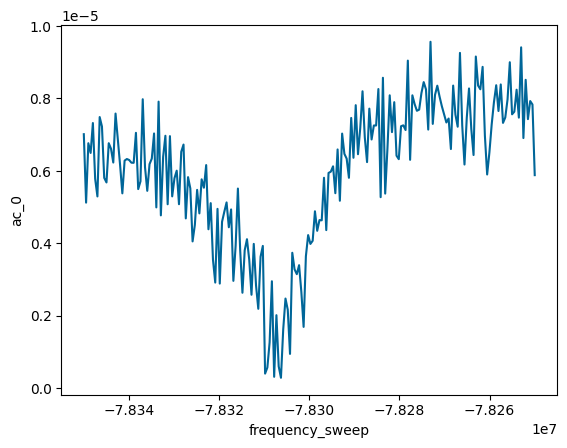

In [178]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=use_emulation)

# set experiment calibration and signal map
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(0))

# run experiment
my_results = session.run(exp)

# plot measurement results
plot_result_2d(my_results, "ac_0")

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
show_pulse_sheet("Resonator Spectroscopy", session.compiled_experiment)

Optional:

In [ ]:
# Run the same experiment on qubit 1
exp.set_calibration(exp_calib)
exp.set_signal_map(map_qubit(1))
my_results = session.run(exp)